# Make some density shells

In [2]:
import numpy as np
from bnt_smooth import TruncatedLognormalWeakLensingSim

In [6]:
# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 1234
l_max = 1500
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside= nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Generate lognormal matter fields from scratch ---
maps = sim.generate_matter_fields_from_scratch()

# --- Print summary ---
print(f"Generated {len(maps)} lognormal HEALPix maps.")
print(f"Each map has {maps[0].size} pixels (nside = {sim.nside})")

print(sim.l_max)

Generated 5 lognormal HEALPix maps.
Each map has 12582912 pixels (nside = 1024)
1500


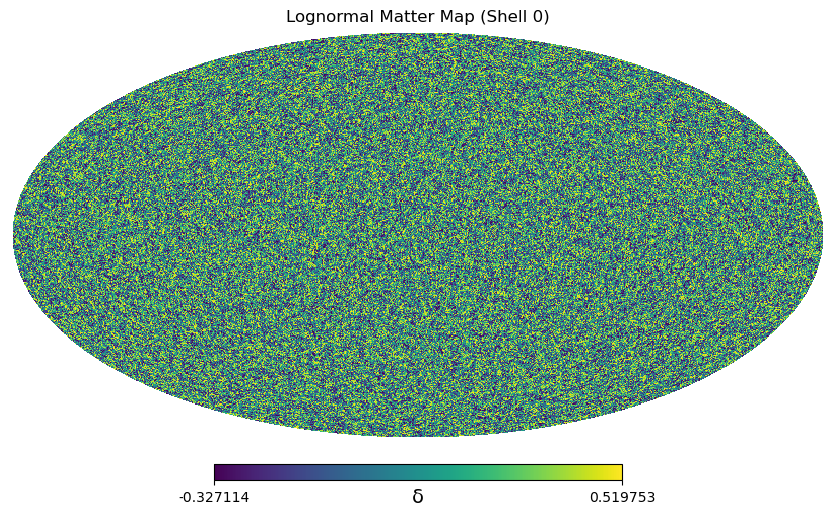

In [7]:
import healpy as hp
import matplotlib.pyplot as plt

# --- Plot the first map (shell 0) ---
hp.mollview(maps[4], title="Lognormal Matter Map (Shell 0)", unit="δ", norm='hist')
plt.show()


# Use these to compute kappa maps

Generated 5 lognormal matter maps.
Computed 3 κ-maps (one per tomographic bin).


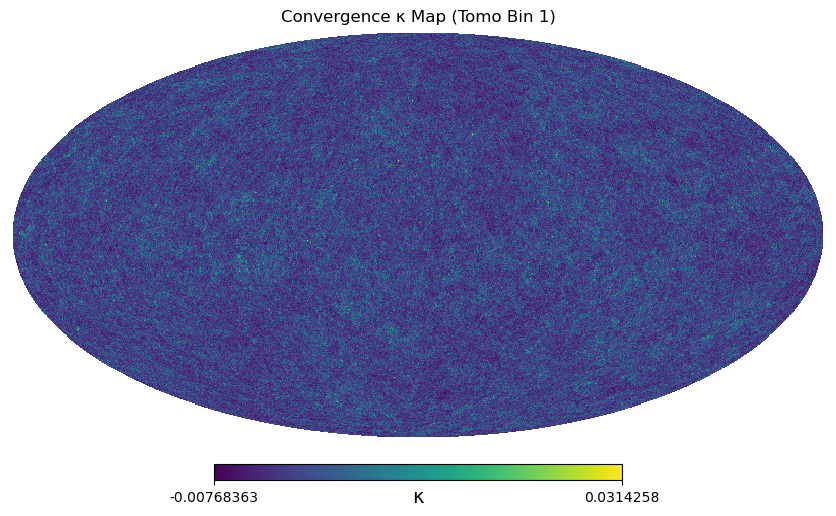

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1500
nside = 512
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside=nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()

# Compute some data vectors and different responses

Computing κ map with lognormal_shift = 0.9
Computing κ map with lognormal_shift = 1.0
Computing κ map with lognormal_shift = 1.1
0.0004285926440958639
0.000476214048995404
0.0005238354538949448


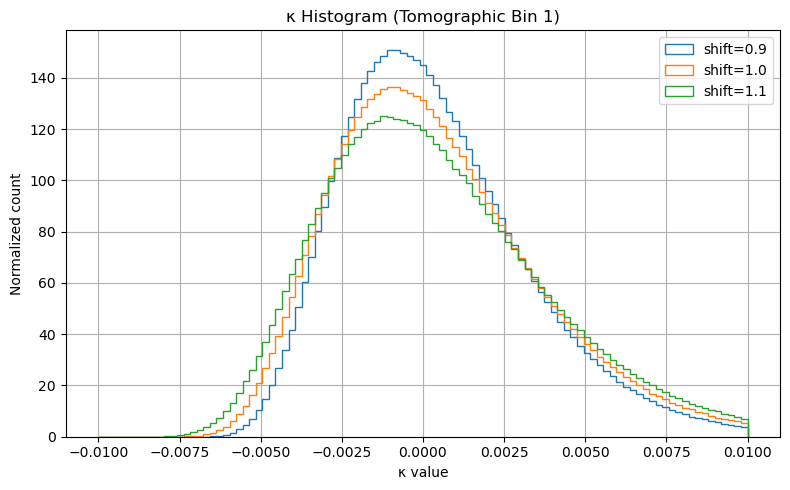

In [9]:

import matplotlib.pyplot as plt

# --- Define shift values to compare ---
shifts = [0.9, 1.0, 1.1, ]
hist_data = []

for shift in shifts:
    print(f"Computing κ map with lognormal_shift = {shift}")
    
    # Set shift and regenerate matter maps
    sim.lognormal_shift = shift
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust range as needed

for i, kappa in enumerate(hist_data):
    print (np.mean(kappa))
    plt.hist(kappa, bins=bins, histtype='step', label=f'shift={shifts[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1)")
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


# visualise what happens for different values of the baryonic feedback parameter

Computing κ map with baryon_feedback = 7.0
Computing κ map with baryon_feedback = 10.0
Mean κ for feedback=7.0: 4.3122e-04
Mean κ for feedback=10.0: 3.0643e-04


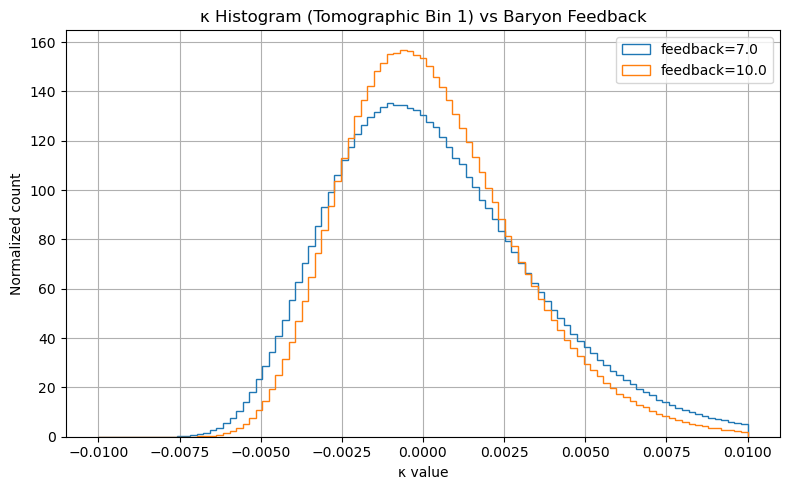

In [10]:
import matplotlib.pyplot as plt

# --- Define baryonic feedback values to compare ---
feedback_values = [7.,10.]
hist_data = []

for feedback in feedback_values:
    print(f"Computing κ map with baryon_feedback = {feedback}")
    
    # Set feedback parameter and regenerate matter maps
    sim.baryon_feedback = feedback
    sim.set_cosmo()
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for feedback={feedback_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'feedback={feedback_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs Baryon Feedback")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
second_moments = [np.var(kappa) for kappa in hist_data]

In [12]:
for feedback, var in zip(feedback_values, second_moments):
    print(f"Feedback {feedback}:  ⟨κ²⟩ = {var:.4e}")

Feedback 7.0:  ⟨κ²⟩ = 1.0746e-05
Feedback 10.0:  ⟨κ²⟩ = 7.4344e-06


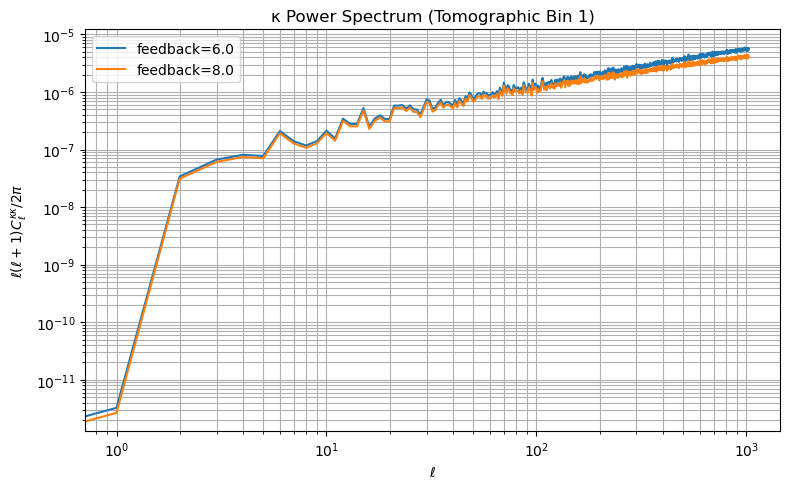

In [9]:
import healpy as hp

# --- Compute C_ell^{κκ} for both maps ---
cl_list = [hp.anafast(kappa, lmax=sim.l_max) for kappa in hist_data]
ell = np.arange(len(cl_list[0]))

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, cl in enumerate(cl_list):
    plt.plot(ell, ell * (ell + 1) * cl / (2 * np.pi), label=f'feedback={feedback_values[i]}')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{\kappa\kappa}/2\pi$')
plt.title('κ Power Spectrum (Tomographic Bin 1)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Computing κ map with sigma8 = 0.75
Computing κ map with sigma8 = 0.8
Computing κ map with sigma8 = 0.85
Mean κ for sigma8=0.75: 2.4785e-04
Mean κ for sigma8=0.8: 2.9514e-04
Mean κ for sigma8=0.85: 3.4748e-04


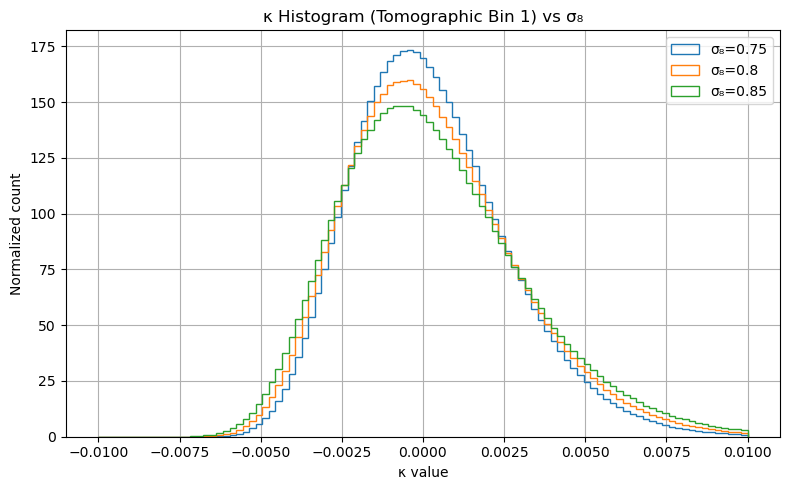

In [10]:
import matplotlib.pyplot as plt

# --- Define sigma8 values to compare ---
sigma8_values = [0.75, 0.8, 0.85]
hist_data = []

for s8 in sigma8_values:
    print(f"Computing κ map with sigma8 = {s8}")
    
    # Set sigma8 and regenerate cosmology and matter maps
    sim.sigma8 = s8
    sim.set_cosmo()
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for sigma8={sigma8_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'σ₈={sigma8_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs σ₈")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make sure the noise is working

Generated 5 lognormal matter maps.
Computed 3 κ-maps (one per tomographic bin).


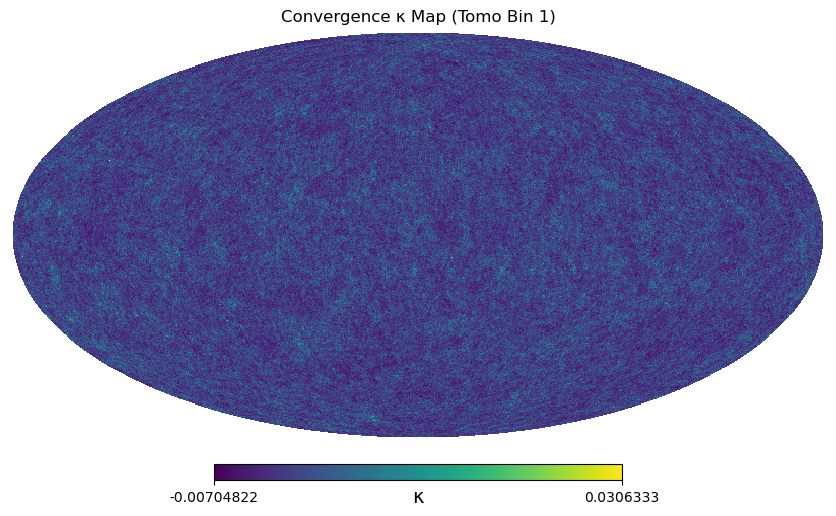

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1024
nside = nside
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside = nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()



Generated 3 noise-only κ-maps.


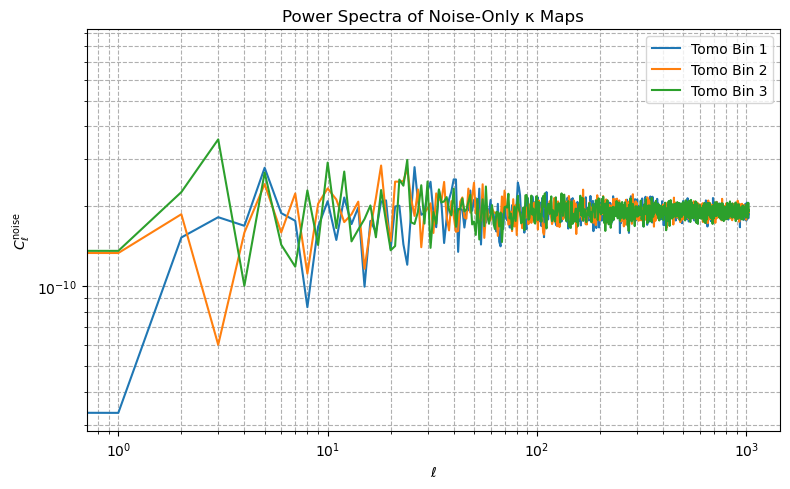

In [12]:
# --- Step 4: Generate noise-only κ maps ---
noise_maps = sim.generate_noise_only_kappa_maps()
print(f"Generated {len(noise_maps)} noise-only κ-maps.")

# --- Step 5: Compute and plot power spectra for noise maps ---
lmax = sim.l_max
ell = np.arange(lmax + 1)

plt.figure(figsize=(8, 5))

for i, noise_map in enumerate(noise_maps):
    cl_noise = hp.anafast(noise_map, lmax=lmax)
    plt.plot(ell, cl_noise, label=f'Tomo Bin {i+1}')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{noise}}$')
plt.title("Power Spectra of Noise-Only κ Maps")
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

# Let's start playing around with the BNT stuff

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim
from bnt_smooth import ProcessMaps

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=5)
n_eff_list = [30.0] * 5
sigma_eps_list = [0.26] * 5
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1024
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = ProcessMaps(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside=nside,
    nslices=nslices
)



In [14]:
kappa_maps = sim.generate_noisy_kappa_maps()

In [15]:
# test all the functions
sim.compute_moments(kappa_maps)
out = sim.get_bnt_matrix()

In [16]:
bnt_kappa_maps = sim.bnt_transform_kappa_maps(kappa_maps)

In [17]:
reversed_kappa_maps = sim.inverse_bnt_transform_kappa_maps(bnt_kappa_maps)

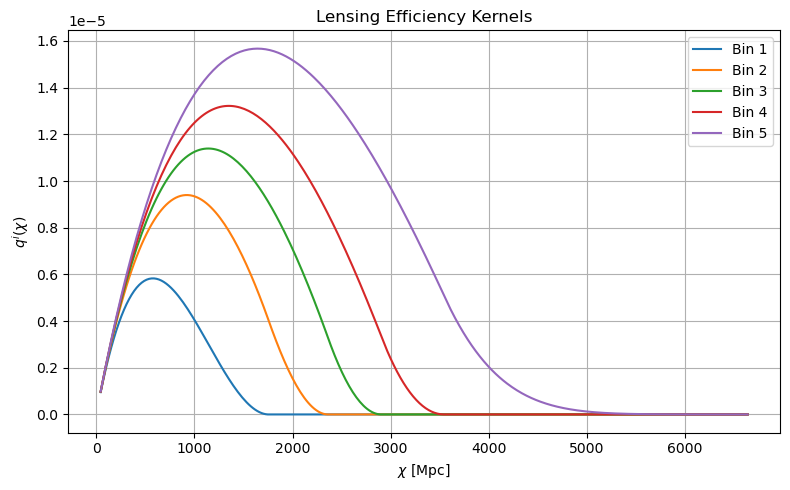

In [18]:
import matplotlib.pyplot as plt

# --- Get chi and q(chi) for all source bins ---
chi, q_list = sim.get_lensing_kernels_on_z_grid()

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, q in enumerate(q_list):
    plt.plot(chi, q, label=f'Bin {i+1}')

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$q^i(\chi)$')
plt.title('Lensing Efficiency Kernels')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

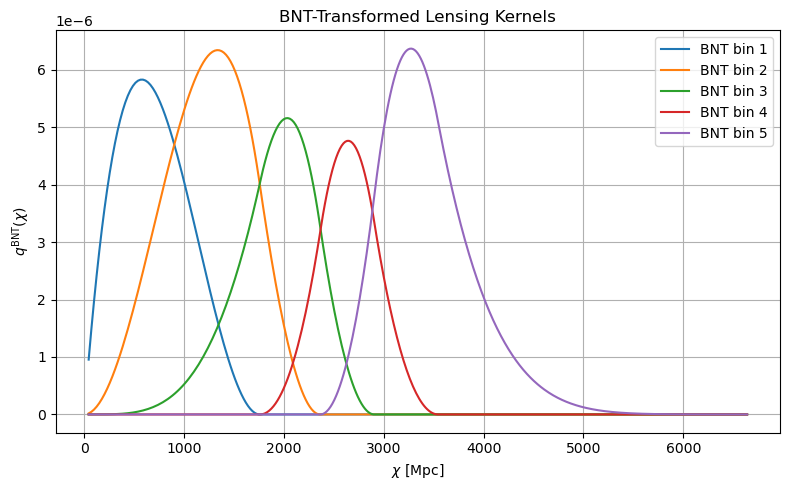

In [19]:
import matplotlib.pyplot as plt

# --- Get χ and BNT-transformed kernels ---
q_bnt_list = sim.bnt_transform_lensing_kernels()

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, q_bnt in enumerate(q_bnt_list):
    plt.plot(chi, q_bnt, label=f'BNT bin {i+1}')

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$q^{\mathrm{BNT}}(\chi)$')
plt.title('BNT-Transformed Lensing Kernels')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
sim.compute_kernel_weighted_mean_chi(chi, q_list)

[np.float64(698.784442472471),
 np.float64(1005.9312127406178),
 np.float64(1255.6201154203172),
 np.float64(1511.3052133913159),
 np.float64(1928.491307511314)]

In [21]:
sim.compute_kernel_weighted_mean_chi(chi, q_bnt_list)

[np.float64(698.784442472471),
 np.float64(1242.6845324766116),
 np.float64(1917.6909514531378),
 np.float64(2646.314954769706),
 np.float64(3434.299712757758)]

# Start on matching Euclid settings

In [23]:
import numpy as np
import numpy as np
from scipy.special import erf
from scipy.interpolate import interp1d


def parent_nz(z):
    z_euc = 0.9 / 2 ** 0.5
    return (z / z_euc) ** 2. * np.exp(-(z / z_euc) ** 1.5)

def make_equal_ngal_bins(nz_func, z_grid, nbins, sigma_z0=0.05):
    """
    Split the parent n(z) into `nbins` tomographic bins with equal galaxy counts
    *and* apply the Euclid photo‑z smoothing of Eq. (115) in Blanchard et al. (2019).

    Parameters
    ----------
    nz_func   : callable
        Parent redshift distribution n(z) (does NOT need to be normalised).
    z_grid    : ndarray
        1‑D grid on which n(z) is evaluated.
    nbins     : int
        Number of tomographic bins.
    sigma_z0  : float, optional
        Photometric redshift error normalisation, σ_z = sigma_z0·(1+z).
        Default 0.05 (Table 5 of Blanchard et al.).

    Returns
    -------
    nz_bins : list
        List of tuples (z_grid, n_i_obs(z)) for each tomographic bin i, where
        each n_i_obs is individually normalised to ∫ n_i_obs dz = 1.
    edges   : ndarray
        Redshift edges z_0 … z_{nbins}.
    """
    # --- parent n(z) (normalised) ------------------------------------------------
    nz_parent = nz_func(z_grid)
    nz_parent /= np.trapz(nz_parent, z_grid)

    # --- cumulative distribution to get equal‑ngal edges -------------------------
    cdf = np.cumsum(nz_parent)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z_grid[0]], z_grid, [z_grid[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))

    # --- photo‑z smoothing (Eq. 115) --------------------------------------------
    nz_bins = []
    sigma_of_z = lambda zz: sigma_z0 * (1.0 + zz)          # σ_z(z)

    for i in range(nbins):
        z_lo, z_hi = edges[i], edges[i + 1]
        sig = sigma_of_z(z_grid)

        # Eq. (115): observed distribution in bin i
        kernel = 0.5 * (erf((z_hi - z_grid) / (np.sqrt(2) * sig))
                        - erf((z_lo - z_grid) / (np.sqrt(2) * sig)))
        nz_i_obs = nz_parent * kernel

        # re‑normalise each bin to unit area
        area = np.trapz(nz_i_obs, z_grid)
        if area > 0:
            nz_i_obs /= area
        nz_bins.append((z_grid, nz_i_obs))

    return nz_bins, edges


# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nbins = 5
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=nbins)
n_eff_list = [30.0/nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
sigma8 = 0.8
seed = 1234
l_max = 3000
nside = 2048
lognormal_shift = 1.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside= nside,
    nslices=nslices
)

import time
begin = time.time()
sim.generate_noisy_kappa_maps()
end = time.time()
print (end - begin)

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20080/1510927953.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nz_parent /= np.trapz(nz_parent, z_grid)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20080/1510927953.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(nz_i_obs, z_grid)


676.0272102355957


/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20080/2828856510.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nz_parent /= np.trapz(nz_parent, z_grid)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20080/2828856510.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(nz_i_obs, z_grid)
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20080/639949502.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nz_parent /= np.trapz(nz_parent, z_grid)


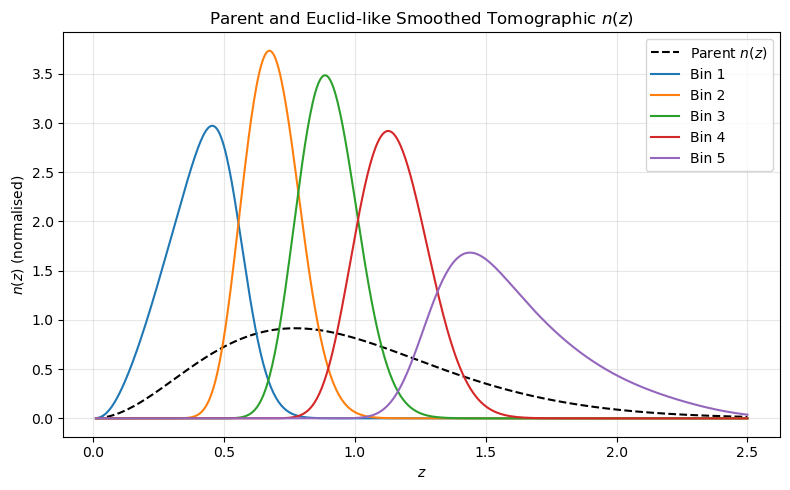

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- Build parent + tomographic n(z) -------------------------------------------------
z_grid = np.linspace(0.01, 2.5, 500)
nbins  = 5
nz_list, edges = make_equal_ngal_bins(parent_nz, z_grid, nbins=nbins)

# --- Plot ---------------------------------------------------------------------------
plt.figure(figsize=(8, 5))

# Parent n(z) (normalised to unit area)
nz_parent = parent_nz(z_grid)
nz_parent /= np.trapz(nz_parent, z_grid)
plt.plot(z_grid, nz_parent, 'k--', lw=1.5, label='Parent $n(z)$')

# Smoothed tomographic bins
for i, (z_bin, nz_bin) in enumerate(nz_list):
    plt.plot(z_bin, nz_bin, label=f'Bin {i+1}')

# Pretty‑up
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$ (normalised)')
plt.title('Parent and Euclid‑like Smoothed Tomographic $n(z)$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Thinking about truncated lognormal

In [54]:
# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 42
l_max = 1500
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = TruncatedLognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    seed=seed,
    l_max=l_max,
    nside= nside,
    nslices=nslices
)

sim.set_cosmo()

0.0

In [55]:
gls = sim.compute_matter_cls()

In [56]:
import healpy as hp
delta_g = hp.synfast(gls[0], nside=nside)

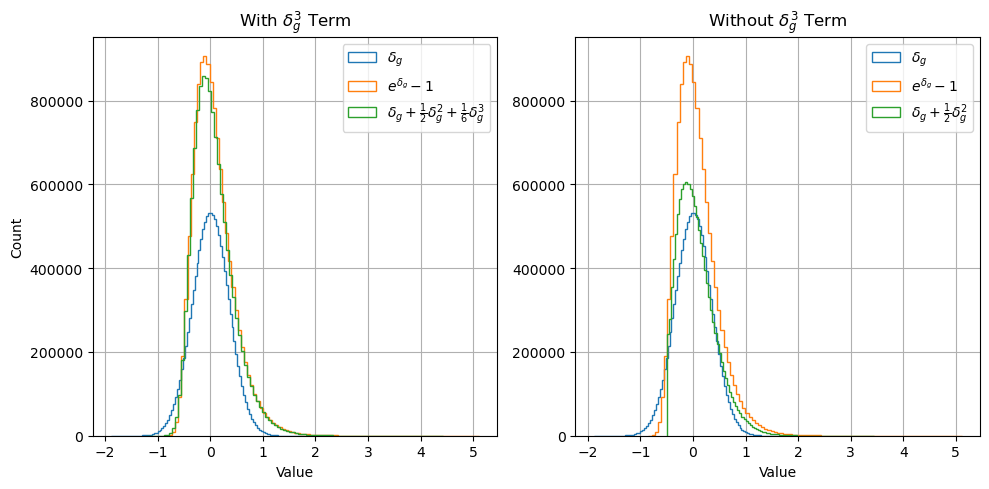

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# Example input if not defined
# delta_g = np.random.normal(0, 0.5, size=100000)

plt.figure(figsize=(10, 5))

# --- Histogram with third-order term included ---
plt.subplot(1, 2, 1)
plt.hist(delta_g, bins=100, histtype='step', label=r'$\delta_g$')
plt.hist(np.exp(delta_g) - 1, bins=100, histtype='step', label=r'$e^{\delta_g} - 1$')
plt.hist(delta_g + 0.5 * delta_g**2 + (1/6.) * delta_g**3, bins=100, histtype='step',
         label=r'$\delta_g + \frac{1}{2}\delta_g^2 + \frac{1}{6}\delta_g^3$')
plt.title("With $\delta_g^3$ Term")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

# --- Histogram with third-order term excluded ---
plt.subplot(1, 2, 2)
plt.hist(delta_g, bins=100, histtype='step', label=r'$\delta_g$')
plt.hist(np.exp(delta_g) - 1, bins=100, histtype='step', label=r'$e^{\delta_g} - 1$')
plt.hist(delta_g + 0.5 * delta_g**2, bins=100, histtype='step',
         label=r'$\delta_g + \frac{1}{2}\delta_g^2$')
plt.title("Without $\delta_g^3$ Term")
plt.xlabel("Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Alpha  Beta    <x²>       <x³>       <x⁴>
----------------------------------------
  0.5   0.5     0.1328     0.0388     0.0675
  0.5   1.0     0.1409     0.0428     0.0819
  0.5   1.5     0.1493     0.0471     0.0991
  1.0   0.5     0.1417     0.0792     0.1054
  1.0   1.0     0.1498     0.0870     0.1249
  1.0   1.5     0.1583     0.0954     0.1479
  1.5   0.5     0.1562     0.1250     0.1718
  1.5   1.0     0.1643     0.1367     0.2000
  1.5   1.5     0.1728     0.1491     0.2322


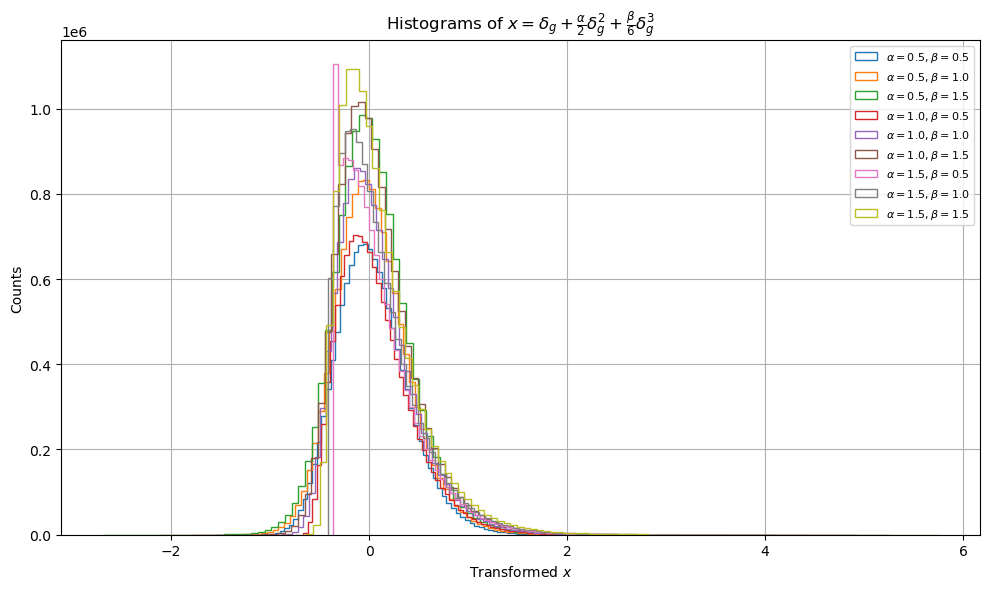

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assume delta_g is already defined
alpha_vals = [0.5, 1.0, 1.5]
beta_vals = [0.5, 1.0, 1.5]

plt.figure(figsize=(10, 6))

print(f"{'Alpha':>5} {'Beta':>5}    <x²>       <x³>       <x⁴>")
print("-" * 40)

for alpha in alpha_vals:
    for beta in beta_vals:
        x = delta_g + 0.5 * alpha * delta_g**2 + (1/6) * beta * delta_g**3
        m2 = np.mean(x**2)
        m3 = np.mean(x**3)
        m4 = np.mean(x**4)

        label = rf"$\alpha={alpha}, \beta={beta}$"
        plt.hist(x, bins=100, histtype='step', label=label, linewidth=1)
        print(f"{alpha:5.1f} {beta:5.1f}  {m2:9.4f}  {m3:9.4f}  {m4:9.4f}")

plt.xlabel(r"Transformed $x$")
plt.ylabel("Counts")
plt.title(r"Histograms of $x = \delta_g + \frac{\alpha}{2} \delta_g^2 + \frac{\beta}{6} \delta_g^3$")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

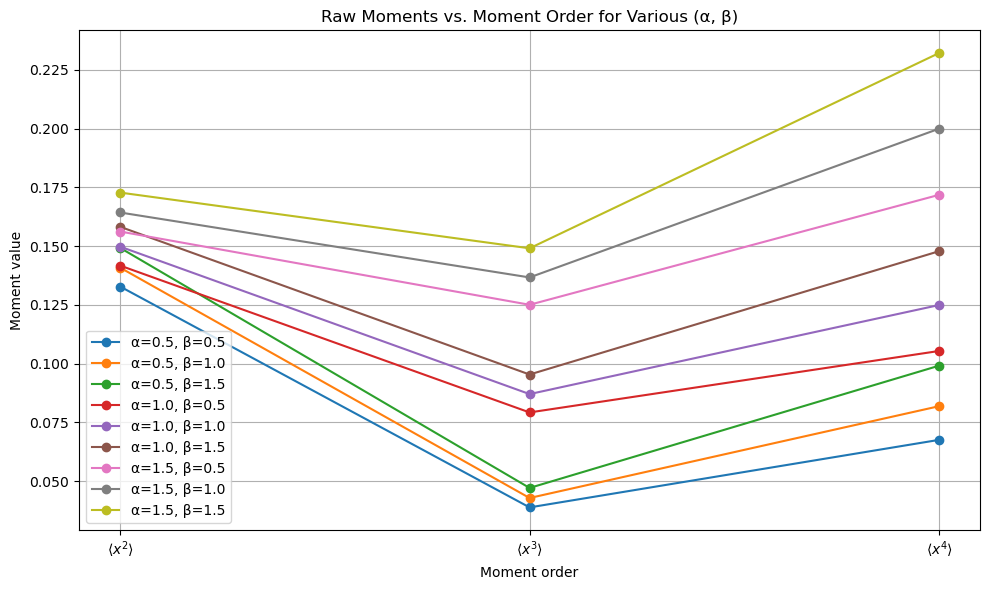

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assume delta_g is already defined
alpha_vals = [0.5, 1.0, 1.5]
beta_vals = [0.5, 1.0, 1.5]

moment_orders = [2, 3, 4]
x_axis = np.array(moment_orders)

plt.figure(figsize=(10, 6))

for alpha in alpha_vals:
    for beta in beta_vals:
        x = delta_g + 0.5 * alpha * delta_g**2 + (1/6) * beta * delta_g**3
        moments = [np.mean(x**k) for k in moment_orders]
        label = f"α={alpha}, β={beta}"
        plt.plot(x_axis, moments, marker='o', label=label)

plt.xticks(x_axis, [r"$\langle x^2 \rangle$", r"$\langle x^3 \rangle$", r"$\langle x^4 \rangle$"])
plt.xlabel("Moment order")
plt.ylabel("Moment value")
plt.title("Raw Moments vs. Moment Order for Various (α, β)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def nonlinear_rescale_to_match_alpha_variance(x, alpha, beta):
    """
    Apply nonlinear transformation and rescale output to have variance = alpha^2.
    
    Parameters
    ----------
    x : ndarray
        Input Gaussian samples.
    alpha : float
        Controls the linear amplitude and target variance (alpha^2).
    beta : float
        Controls the strength of nonlinear terms.
    
    Returns
    -------
    y : ndarray
        Transformed and rescaled samples with variance alpha^2.
    """
    y = alpha * x + beta * (0.5 * x**2 + (1/6.0) * x**3)
    var_target = alpha**2
    var_y = np.var(y)
    y *= np.sqrt(var_target / var_y)
    return y

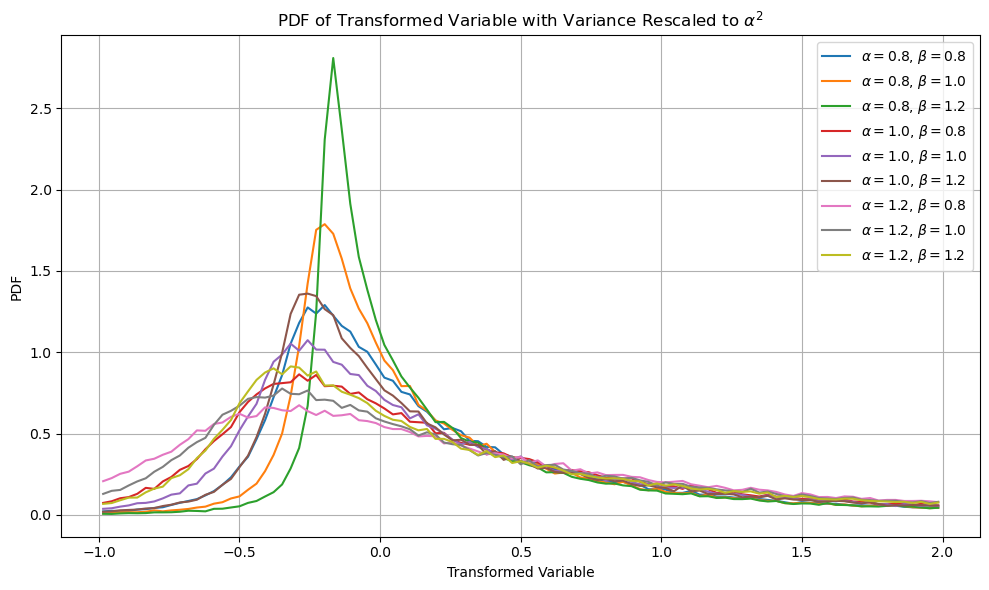

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_rescale_to_match_alpha_variance(x, alpha, beta):
    y = alpha * x + beta * (0.5 * x**2 + (1/6.0) * x**3)
    var_target = alpha**2
    var_y = np.var(y)
    y *= np.sqrt(var_target / var_y)
    return y

# Generate Gaussian samples
x = np.random.normal(0, 1, size=100000)

# Grid of alpha and beta values
alphas = [0.8, 1.0, 1.2]
betas = [0.8, 1.0, 1.2]

# Plot settings
plt.figure(figsize=(10, 6))
bins = np.linspace(-1, 2, 100)

for alpha in alphas:
    for beta in betas:
        y = nonlinear_rescale_to_match_alpha_variance(x, alpha, beta)
        counts, edges = np.histogram(y, bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        label = rf"$\alpha={alpha}$, $\beta={beta}$"
        plt.plot(centers, counts, label=label)

plt.xlabel("Transformed Variable")
plt.ylabel("PDF")
plt.title("PDF of Transformed Variable with Variance Rescaled to $\\alpha^2$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

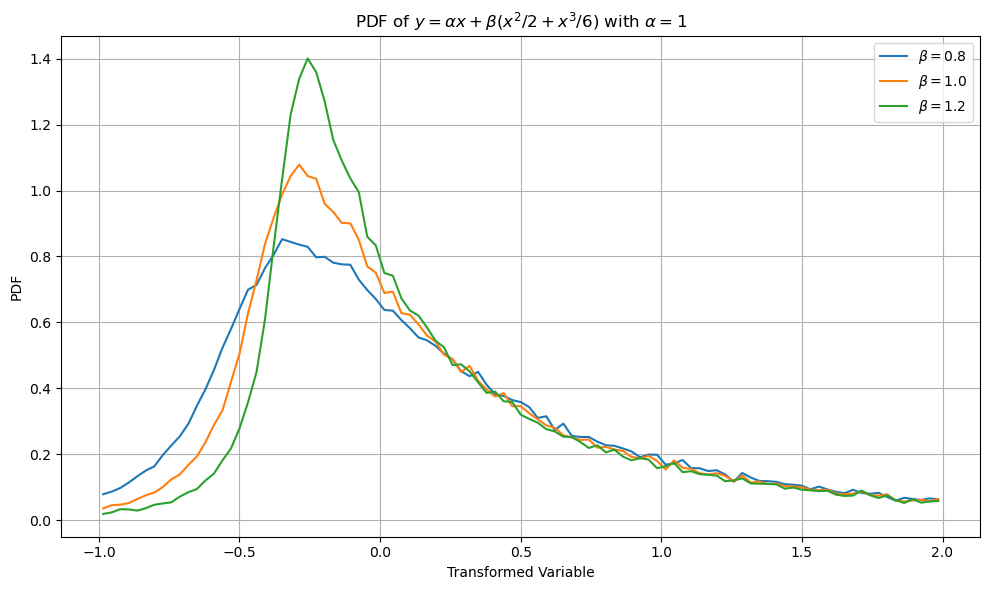

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_rescale_to_match_alpha_variance(x, alpha, beta):
    y = alpha * x + beta * (0.5 * x**2 + (1/6.0) * x**3)
    var_target = alpha**2
    var_y = np.var(y)
    y *= np.sqrt(var_target / var_y)
    return y

# Generate Gaussian samples
x = np.random.normal(0, 1, size=100000)

# Fixed alpha
alpha = 1.0
betas = [0.8, 1.0, 1.2]

# Plot
plt.figure(figsize=(10, 6))
bins = np.linspace(-1, 2, 100)

for beta in betas:
    y = nonlinear_rescale_to_match_alpha_variance(x, alpha, beta)
    counts, edges = np.histogram(y, bins=bins, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    label = rf"$\beta={beta}$"
    plt.plot(centers, counts, label=label)

plt.xlabel("Transformed Variable")
plt.ylabel("PDF")
plt.title(r"PDF of $y = \alpha x + \beta (x^2/2 + x^3/6)$ with $\alpha=1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

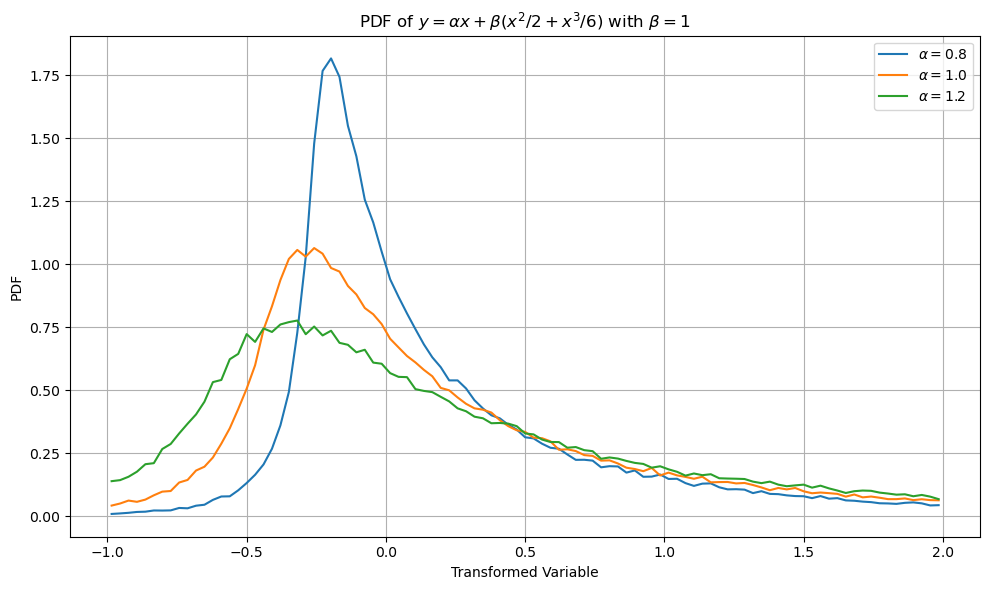

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_rescale_to_match_alpha_variance(x, alpha, beta):
    y = alpha * x + beta * (0.5 * x**2 + (1/6.0) * x**3)
    var_target = alpha**2
    var_y = np.var(y)
    y *= np.sqrt(var_target / var_y)
    return y

# Generate Gaussian samples
x = np.random.normal(0, 1, size=100000)

# Fixed beta
beta = 1.0
alphas = [0.8, 1.0, 1.2]

# Plot
plt.figure(figsize=(10, 6))
bins = np.linspace(-1, 2, 100)

for alpha in alphas:
    y = nonlinear_rescale_to_match_alpha_variance(x, alpha, beta)
    counts, edges = np.histogram(y, bins=bins, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    label = rf"$\alpha={alpha}$"
    plt.plot(centers, counts, label=label)

plt.xlabel("Transformed Variable")
plt.ylabel("PDF")
plt.title(r"PDF of $y = \alpha x + \beta (x^2/2 + x^3/6)$ with $\beta=1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
x = delta_g

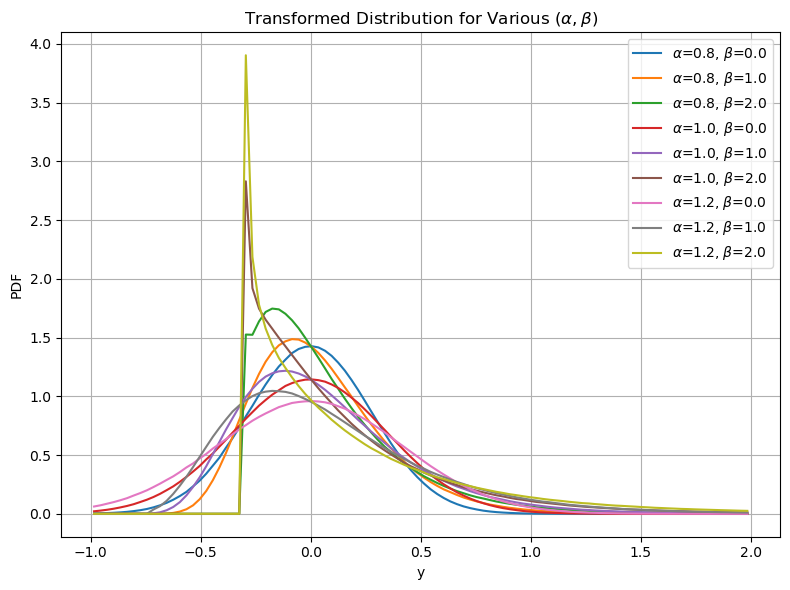

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Define transformation function
def nonlinear_transform_scaled_input(x, alpha, beta):
    ax = alpha  * x
    return ax + beta * ((0.5 * ax**2)  + (1.0 / 6.0) * ax**3 + (1.0/24.) * ax**4.)

# Sample from a standard normal distribution


# Parameter values to explore
alpha_vals = [0.8, 1.0, 1.2]
beta_vals = [0., 1.0, 2.0]

# Plot setup
plt.figure(figsize=(8, 6))

# Iterate over combinations of alpha and beta
for alpha in alpha_vals:
    for beta in beta_vals:
        y = nonlinear_transform_scaled_input(x, alpha, beta)
        hist, bins = np.histogram(y, bins=100, range=(-1, 2), density=True)
        centers = 0.5 * (bins[:-1] + bins[1:])
        label = f"$\\alpha$={alpha}, $\\beta$={beta}"
        plt.plot(centers, hist, label=label)

# Finalize plot
plt.xlabel("y")
plt.ylabel("PDF")
plt.title("Transformed Distribution for Various $(\\alpha, \\beta)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
import numpy as np

def nonlinear_transform_alpha_beta(x, alpha, beta):
    """
    Apply the transformation:
        y = alpha * (x + beta * (1/2 * x^2 + 1/6 * x^3))
    
    Parameters
    ----------
    x : ndarray
        Input array of samples.
    alpha : float
        Scaling for the entire expression.
    beta : float
        Scaling for the nonlinear (quadratic + cubic) term.
    
    Returns
    -------
    y : ndarray
        Transformed array.
    """
    return alpha * (x + beta * (0.5 * x**2 + (1.0 / 6.0) * x**3))

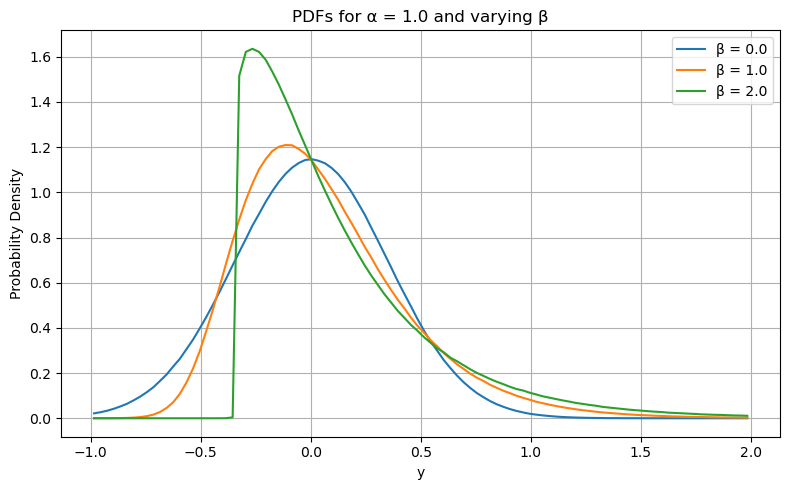

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_transform_alpha_beta(x, alpha, beta):
    return alpha * (x + beta * (0.5 * x**2 + (1.0 / 6.0) * x**3))

# Generate Gaussian samples


# Fixed alpha
alpha = 1.0
beta_vals = [0., 1.0, 2.0]

# Histogram settings
bins = 100
x_range = (-1, 2)

plt.figure(figsize=(8, 5))

for beta in beta_vals:
    y = nonlinear_transform_alpha_beta(x, alpha, beta)
    hist, edges = np.histogram(y, bins=bins, range=x_range, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    plt.plot(centers, hist, label=f"β = {beta}")

plt.xlabel("y")
plt.ylabel("Probability Density")
plt.title(f"PDFs for α = {alpha} and varying β")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

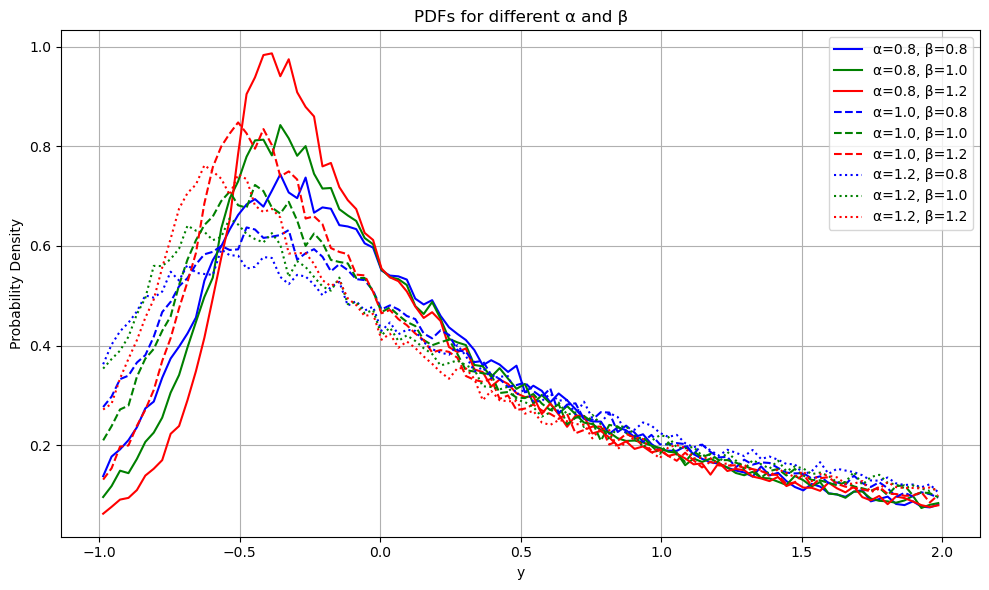

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_transform_alpha_beta(x, alpha, beta):
    return alpha * (x + beta * (0.5 * x**2 + (1.0 / 6.0) * x**3))

# Gaussian input
np.random.seed(0)
x = np.random.normal(loc=0.0, scale=1.0, size=100000)

alpha_vals = [0.8, 1.0, 1.2]
beta_vals = [0.8, 1.0, 1.2]

colors = ['blue', 'green', 'red']
linestyles = ['-', '--', ':']

# Plot setup
plt.figure(figsize=(10, 6))
bins = 100
x_range = (-1, 2)

for i, alpha in enumerate(alpha_vals):
    for j, beta in enumerate(beta_vals):
        y = nonlinear_transform_alpha_beta(x, alpha, beta)
        hist, edges = np.histogram(y, bins=bins, range=x_range, density=True)
        centers = 0.5 * (edges[1:] + edges[:-1])
        label = f"α={alpha}, β={beta}"
        plt.plot(centers, hist, color=colors[j], linestyle=linestyles[i], label=label)

plt.xlabel("y")
plt.ylabel("Probability Density")
plt.title("PDFs for different α and β")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Try again

In [60]:
import numpy as np

def nonlinear_transform_rescale_second_moment(x, alpha, beta):
    ax = alpha * x
    y = alpha * x + beta * (0.5 * ax**2 + (1/6.0) * ax**3)
    current_second_moment = np.mean(y**2)
    target_second_moment = alpha**2
    scale_factor = np.sqrt(target_second_moment / current_second_moment)
    y_rescaled = y * scale_factor
    return y_rescaled

# Gaussian input
x = delta_g

alpha = 1.0
beta_vals = [0.8, 1.0, 1.2]

print("Second moment ⟨y²⟩ for α = 1.0 (after rescaling):")
for beta in beta_vals:
    y = nonlinear_transform_rescale_second_moment(x, alpha, beta)
    moment2 = np.mean(y**2)
    print(f"  β = {beta:.1f}  →  ⟨y²⟩ = {moment2:.5f}")

Second moment ⟨y²⟩ for α = 1.0 (after rescaling):
  β = 0.8  →  ⟨y²⟩ = 1.00000
  β = 1.0  →  ⟨y²⟩ = 1.00000
  β = 1.2  →  ⟨y²⟩ = 1.00000


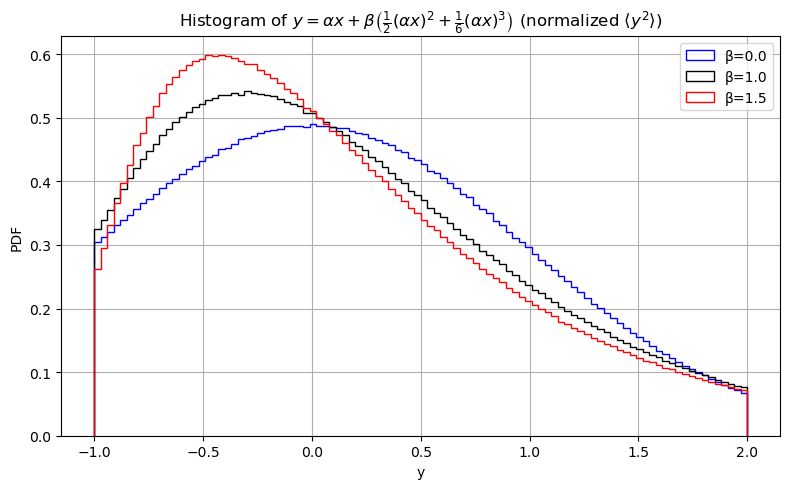

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_transform_rescale_second_moment(x, alpha, beta):
    ax = alpha * x
    y = alpha * x + beta * (0.5 * ax**2 + (1/6.0) * ax**3)
    current_second_moment = np.mean(y**2)
    target_second_moment = alpha**2
    scale_factor = np.sqrt(target_second_moment / current_second_moment)
    return y * scale_factor

# Input Gaussian field
x = delta_g

# Parameters
alpha = 1.0
beta_vals = [0., 1.0, 1.5]
colors = ['blue', 'black', 'red']

# Plot
plt.figure(figsize=(8, 5))
for beta, color in zip(beta_vals, colors):
    y = nonlinear_transform_rescale_second_moment(x, alpha, beta)
    plt.hist(y, bins=100, range=(-1, 2), histtype='step', density=True, label=f'β={beta}', color=color)

plt.xlabel('y')
plt.ylabel('PDF')
plt.title(r'Histogram of $y = \alpha x + \beta \left(\frac{1}{2}(\alpha x)^2 + \frac{1}{6}(\alpha x)^3\right)$ (normalized ⟨$y^2$⟩)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# power las transform

In [87]:
import numpy as np

def power_law_transform(x, alpha=2.0, beta=1.0):
    """
    Compute y = alpha^(beta * x) - 1

    Parameters
    ----------
    x : ndarray
        Input array (e.g., Gaussian random field)
    alpha : float
        Base of the power (must be > 0)
    beta : float
        Exponent scaling factor

    Returns
    -------
    y : ndarray
        Transformed output
    """
    return np.power(alpha, beta * x) - 1

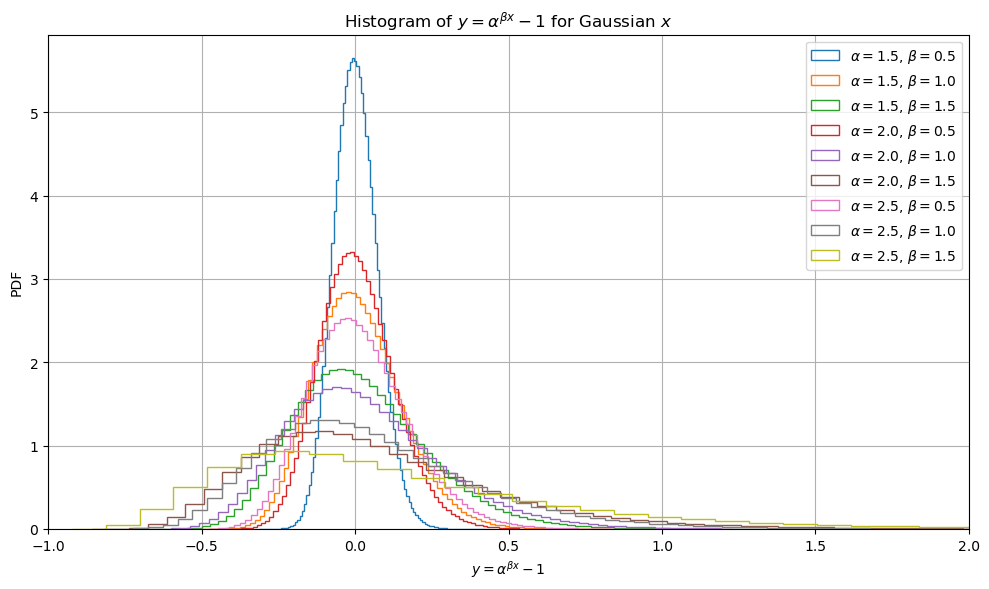

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Transformation function
def power_transform(x, alpha, beta):
    return alpha ** (beta * x) - 1

# Parameter combinations
alphas = [1.5, 2.0, 2.5]
betas = [0.5, 1.0, 1.5]

# Plot histograms
plt.figure(figsize=(10, 6))
for alpha in alphas:
    for beta in betas:
        y = power_transform(x, alpha, beta)
        label = f"$\\alpha={alpha}$, $\\beta={beta}$"
        plt.hist(y, bins=100, density=True, histtype='step', label=label)

plt.xlim(-1, 2)  # Adjust if needed
plt.xlabel("$y = \\alpha^{\\beta x} - 1$")
plt.ylabel("PDF")
plt.title("Histogram of $y = \\alpha^{\\beta x} - 1$ for Gaussian $x$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()